In [1]:
# Run if you want to get rid of water, leave only protein and make the molecules whole
! echo 1 | gmx trjconv -f ../dynamic.xtc -s ../dynamic.tpr -o vars/output_no_water.xtc -pbc mol # make the molecules whole again!
! echo 1 | gmx trjconv -f ../dynamic.gro -s ../dynamic.tpr -o vars/output_no_water.gro -pbc mol

cat: write error: Broken pipe
               :-) GROMACS - gmx trjconv, 2024.2-conda_forge (-:

Executable:   /opt/conda/envs/gromacs/bin.AVX2_256/gmx
Data prefix:  /opt/conda/envs/gromacs
Working dir:  /home/alexeyk/Desktop/simulations/Finished/serf_peg/MDanal
Command line:
  gmx trjconv -f ../dynamic.xtc -s ../dynamic.tpr -o vars/output_no_water.xtc -pbc mol

Note that major changes are planned in future for trjconv, to improve usability and utility.
Will write xtc: Compressed trajectory (portable xdr format): xtc
Reading file ../dynamic.tpr, VERSION 2024.2-conda_forge (single precision)
Reading file ../dynamic.tpr, VERSION 2024.2-conda_forge (single precision)
Select group for output
Group     0 (         System) has 230186 elements
Group     1 (        Protein) has  6450 elements
Group     2 (      Protein-H) has  6450 elements
Group     3 (        C-alpha) has     0 elements
Group     4 (       Backbone) has     0 elements
Group     5 (      MainChain) has     0 elements
Group    

In [2]:

import MDAnalysis as mda
import numpy as np
# Load the simulation files

u= mda.Universe("vars/output_no_water.gro", "vars/output_no_water.xtc")
# test with unwrapped
#u= mda.Universe("unwrapped_no_water.gro", "unwrapped_no_water.xtc")
NUM_RES = 59
NUM_PROTEINS = 50
PROTEIN_LEN = 129

proteins = []

# this selects all 50 atoms
for i in range(NUM_PROTEINS):
    max_atoms = NUM_PROTEINS * PROTEIN_LEN
    start_index = i * PROTEIN_LEN + 1
    end_index = (i + 1) * PROTEIN_LEN
    proteins.append(u.select_atoms(f"bynum {start_index}:{end_index}"))

coms = [] #array that will contain centers of mass
for ts in u.trajectory:
    frame_coms = np.array([protein.center_of_mass() for protein in proteins])
    coms.append(frame_coms)
coms = np.array(coms)
print(coms.shape)
print(proteins)
    




(2001, 50, 3)
[<AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <AtomGroup with 129 atoms>, <Atom

In [3]:
from MDAnalysis.analysis import contacts
from MDAnalysis.analysis import distances
from MDAnalysis.analysis.rms import rmsd
def get_minimal_distance(u, group_a, group_b):
    # Preallocate arrays
    com_dist = []
    for i, ts in enumerate(u.trajectory):
        res_com1 = group_a.center_of_mass(compound='residues')
        res_com2 = group_b.center_of_mass(compound='residues')
         
        com_dist.append(np.min(distances.distance_array(res_com1, res_com2,
                                    box=u.dimensions)))
    return com_dist

# calculate distances between each pair of residues (taken from different groups)
def get_distances(u, group_a, group_b):
    # Preallocate arrays
    com_dist = []
    for i, ts in enumerate(u.trajectory):
        res_com1 = group_a.center_of_mass(compound='residues')
        res_com2 = group_b.center_of_mass(compound='residues')
         
        com_dist.append(np.mean(distances.distance_array(res_com1, res_com2,
                                    box=u.dimensions)))
    return com_dist

# def calculate_rmsd(u, group_a, group_b):
#     num_frames = len(u.trajectory)
#     rmsd_frames = np.zeros([num_frames])
#     for i, ts in enumerate(u.trajectory):
#         rmsd_frames[i] = rmsd(group_a.center_of_mass(compound='residues'), group_b.center_of_mass(compound='residues'))
#     return rmsd_frames

In [5]:
from joblib import Parallel, delayed
import numpy as np
# dist_1_2 = get_distances(u, proteins[1], proteins[2])
# rmsd12 = calculate_rmsd(u, proteins[1], proteins[2])
# print(dist_1_2.shape)
# print(rmsd12.shape)
def compute_rmsd_for_parallel(i, j):
    u= mda.Universe("vars/output_no_water.gro", "vars/output_no_water.xtc")
    group_a = u.select_atoms(f"bynum {i * PROTEIN_LEN + 1}:{(i + 1) * PROTEIN_LEN}")
    group_b = u.select_atoms(f"bynum {j * PROTEIN_LEN + 1}:{(j + 1) * PROTEIN_LEN}")
    #return (i, j, calculate_rmsd(u, group_a, group_b))
    #return (i, j, get_distances(u, group_a, group_b))
    return (i, j, get_minimal_distance(u, group_a, group_b))



    

# for i in range(NUM_PROTEINS):
#     for j in range(i, NUM_PROTEINS):
#         rmsd_ij = calculate_rmsd(u, proteins[i], proteins[j])
def parallel_rmsd_calculation(num_proteins):
    """Parallel computation of RMSD for all pairs of proteins across all frames."""
    num_frames = len(u.trajectory)
    rmsd_3d = np.zeros((num_frames, num_proteins, num_proteins))
    results = Parallel(n_jobs=32)(
        delayed(compute_rmsd_for_parallel)(i, j)
        for i in range(num_proteins)
        for j in range(i, num_proteins)
    )
    # Populate the 3D array
    for i, j, rmsd_frames in results:
        rmsd_3d[:, i, j] = rmsd_frames  # Upper triangle
        rmsd_3d[:, j, i] = rmsd_frames  # Symmetric lower triangle
    
    return rmsd_3d     
        
rmsd_3d_array = parallel_rmsd_calculation(NUM_PROTEINS)
print(rmsd_3d_array.shape)
np.save("vars/rmsd_3d_array.npy", rmsd_3d_array)

(2001, 50, 50)


In [ ]:
import networkx as nx
import numpy as np

# this is so you don't have to recompute over and over
rmsd_3d_array = np.load("vars/rmsd_3d_array.npy")

def graph_based_clustering(rmsd_matrix, cutoff):
    """
    Perform graph-based clustering for a single frame.
    Nodes are connected if RMSD is below the cutoff.
    """
    num_proteins = rmsd_matrix.shape[0]
    G = nx.Graph()

    # Add nodes
    G.add_nodes_from(range(num_proteins))

    # Add edges for pairs below the cutoff
    for i in range(num_proteins):
        for j in range(i + 1, num_proteins):
            if rmsd_matrix[i, j] < cutoff:
                G.add_edge(i, j)

    # Find connected components (clusters)
    clusters = [list(component) for component in nx.connected_components(G)]
    return clusters

def cluster_all_frames(rmsd_3d, cutoff):
    """
    Perform clustering for each frame in the trajectory.
    """
    num_frames = rmsd_3d.shape[0]
    clusters_per_frame = {}

    for frame_idx in range(num_frames):
        rmsd_matrix = rmsd_3d[frame_idx]
        clusters = graph_based_clustering(rmsd_matrix, cutoff)
        clusters_per_frame[frame_idx] = clusters

    return clusters_per_frame

In [ ]:
# # Example usage
# cutoff_value = 5.0  # Adjust as needed
# clusters_per_frame = cluster_all_frames(rmsd_3d_array, cutoff_value)

# # Print clusters for the first few frames
# for frame, clusters in list(clusters_per_frame.items()):
#     print(f"Frame {frame}: {len(clusters)}")

Frame 0: 46
Frame 1: 45
Frame 2: 47
Frame 3: 48
Frame 4: 44
Frame 5: 44
Frame 6: 44
Frame 7: 45
Frame 8: 44
Frame 9: 44
Frame 10: 43
Frame 11: 42
Frame 12: 43
Frame 13: 43
Frame 14: 42
Frame 15: 43
Frame 16: 41
Frame 17: 43
Frame 18: 42
Frame 19: 41
Frame 20: 42
Frame 21: 45
Frame 22: 46
Frame 23: 44
Frame 24: 45
Frame 25: 44
Frame 26: 41
Frame 27: 43
Frame 28: 42
Frame 29: 45
Frame 30: 46
Frame 31: 45
Frame 32: 44
Frame 33: 42
Frame 34: 43
Frame 35: 42
Frame 36: 42
Frame 37: 44
Frame 38: 40
Frame 39: 39
Frame 40: 41
Frame 41: 37
Frame 42: 39
Frame 43: 41
Frame 44: 42
Frame 45: 41
Frame 46: 38
Frame 47: 38
Frame 48: 39
Frame 49: 40
Frame 50: 38
Frame 51: 37
Frame 52: 38
Frame 53: 40
Frame 54: 40
Frame 55: 39
Frame 56: 38
Frame 57: 38
Frame 58: 37
Frame 59: 38
Frame 60: 39
Frame 61: 39
Frame 62: 37
Frame 63: 40
Frame 64: 38
Frame 65: 40
Frame 66: 38
Frame 67: 38
Frame 68: 39
Frame 69: 39
Frame 70: 41
Frame 71: 40
Frame 72: 41
Frame 73: 35
Frame 74: 38
Frame 75: 38
Frame 76: 40
Frame 77:

In [9]:
cutoffs = [5.0, 10, 15, 20, 25, 30]
clusts = []
for cutoff in cutoffs:
    clusts.append(cluster_all_frames(rmsd_3d_array, cutoff))

In [19]:
import matplotlib.pyplot as plt

# This function is for plotting clusterizations
def plot_cluster(clusters_per_frame, cutoff):
    num_clusters = [len(clusters) for clusters in clusters_per_frame.values()]
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(num_clusters)), num_clusters,label='Number of Clusters', marker='o', markersize=4)
    plt.xlabel("Frame")
    plt.ylabel("Number of Clusters")
    plt.title(f"Number of Clusters Per Frame. Cutoff ={cutoff}A")
    plt.legend()
    plt.show

    average_cluster_sizes = []
    frames = []

    # increase n to average over frames and reduce noise
    avg_over_n = 0
    n = 5
    for frame, clusters in clusters_per_frame.items():
        total_size = sum(len(cluster) for cluster in clusters)
        avg_size = total_size / len(clusters) if clusters else 0 # make sure to handle 0 case
        if ((frame % n == 0) and (frame != 0)):
            average_cluster_sizes.append(avg_over_n/n)
            avg_over_n = avg_size
            frames.append(frame)
        else:
            avg_over_n += avg_size
    plt.figure(figsize=(12, 6))
    plt.plot(frames, average_cluster_sizes, label='Average Cluster Size', marker='o', markersize=4)
    plt.xlabel('Frame')
    plt.ylabel('Average Cluster Size')
    plt.title(f'Average Cluster Size vs Frame. Cutoff ={cutoff}A')
    plt.grid(True)
    plt.show()
    return frames

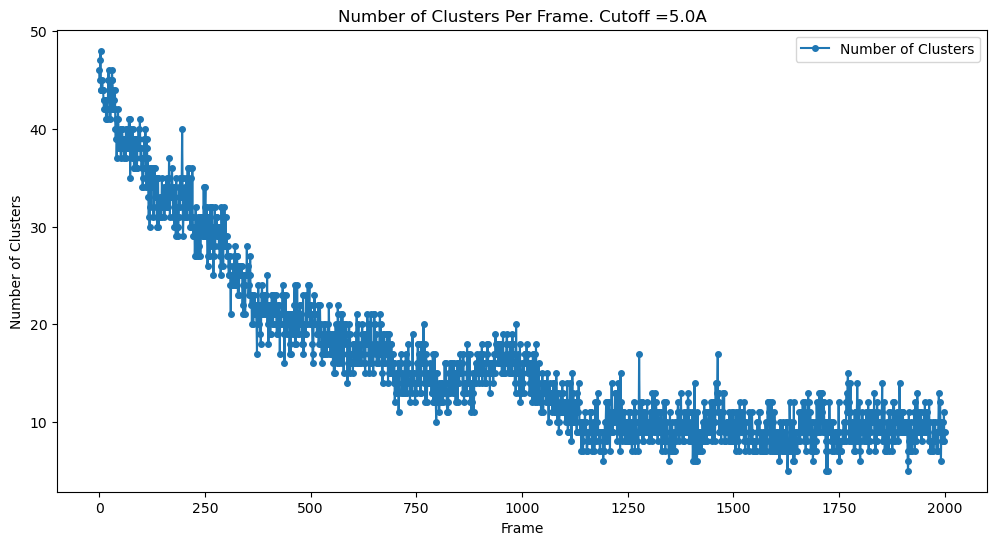

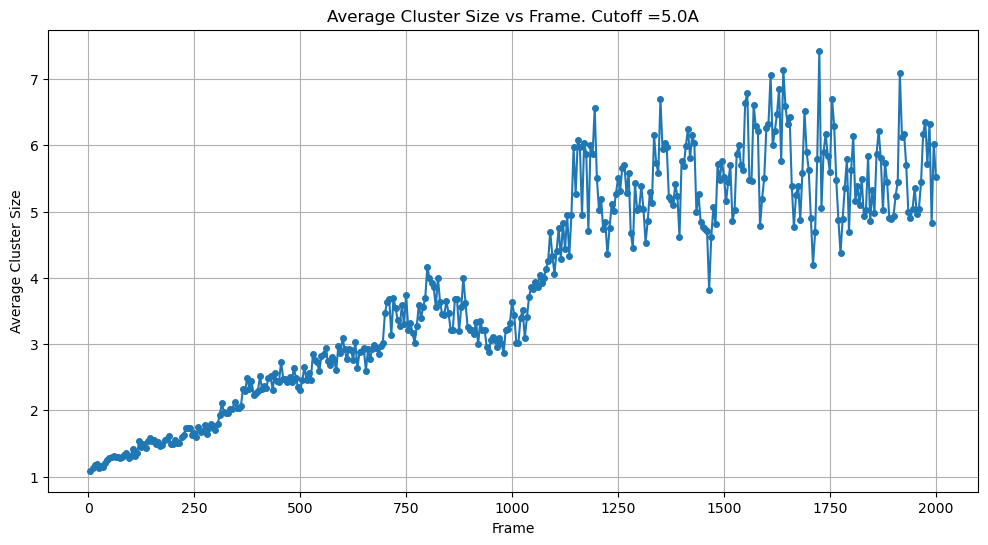

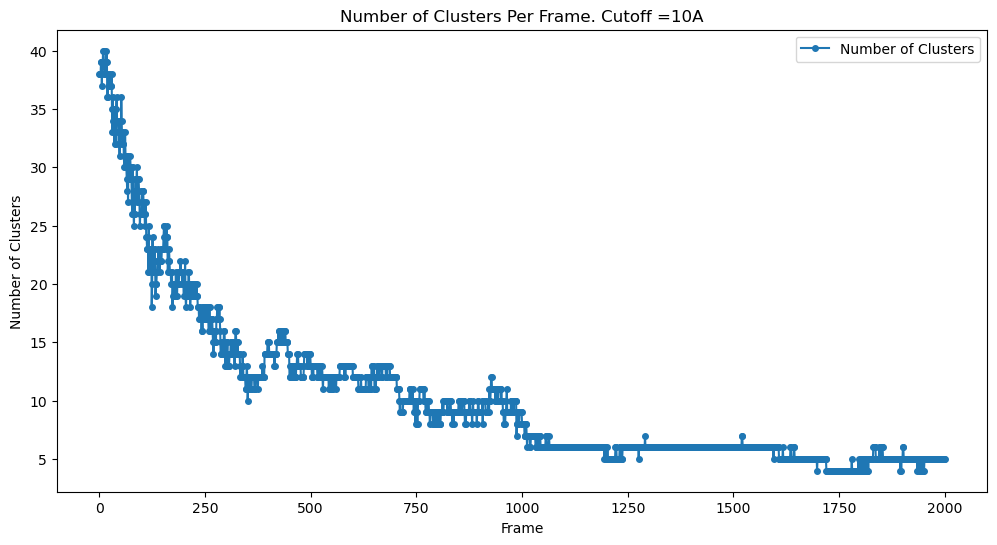

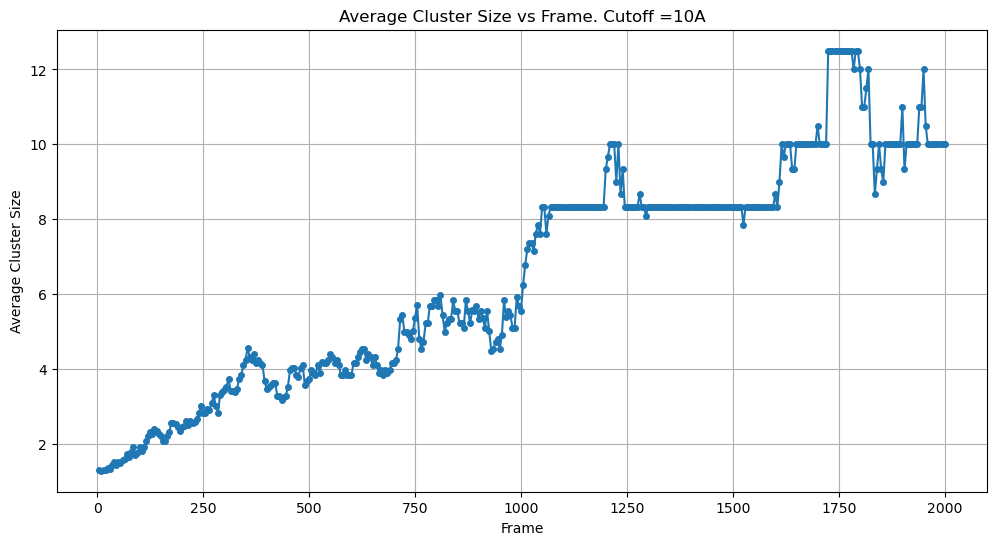

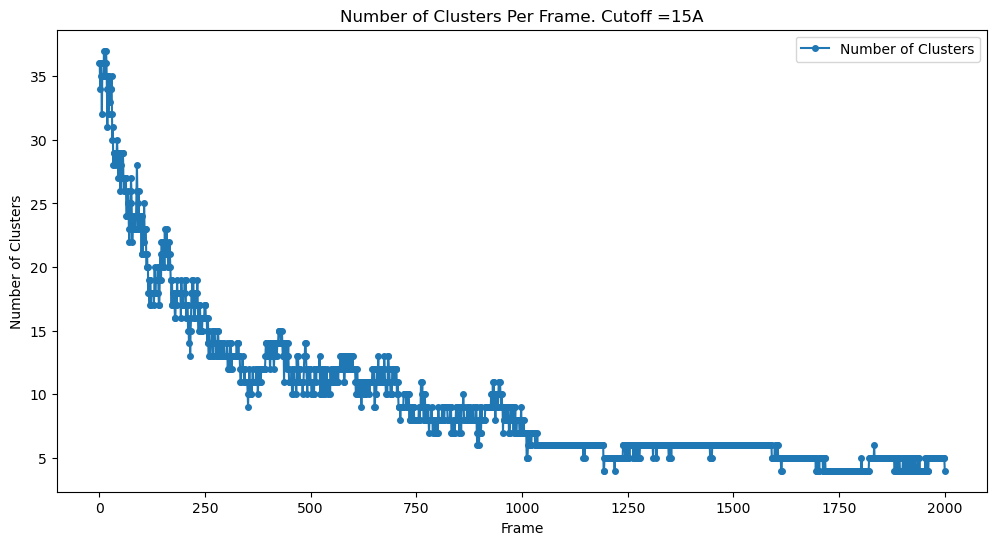

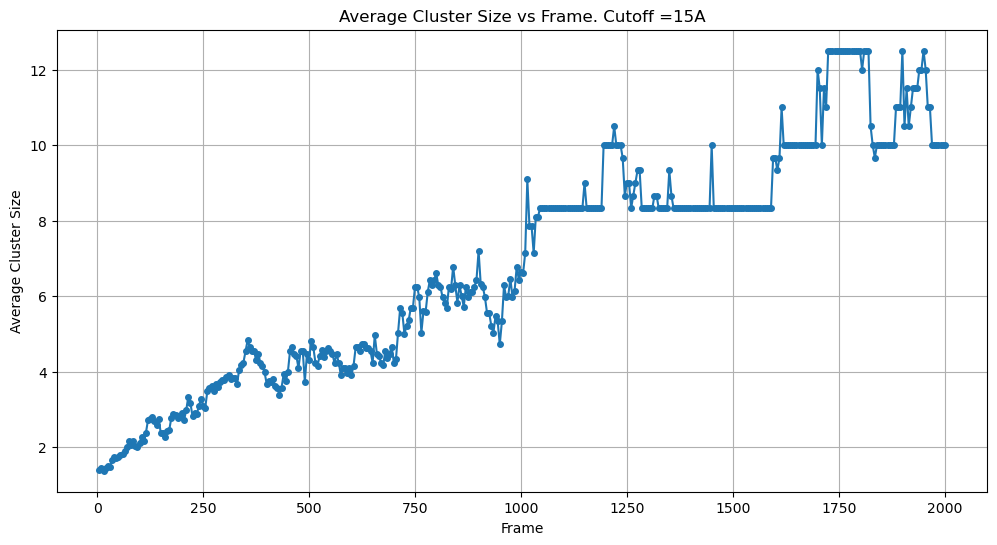

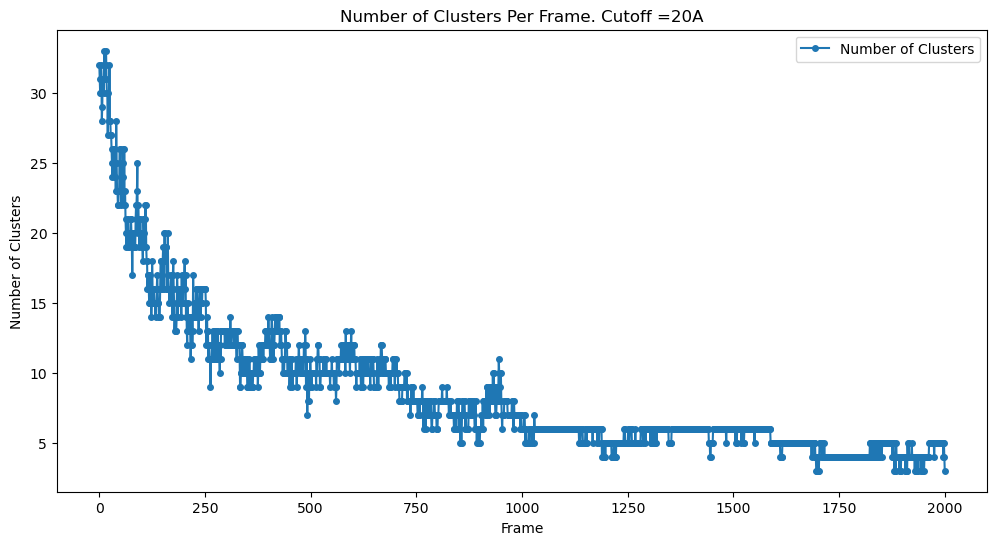

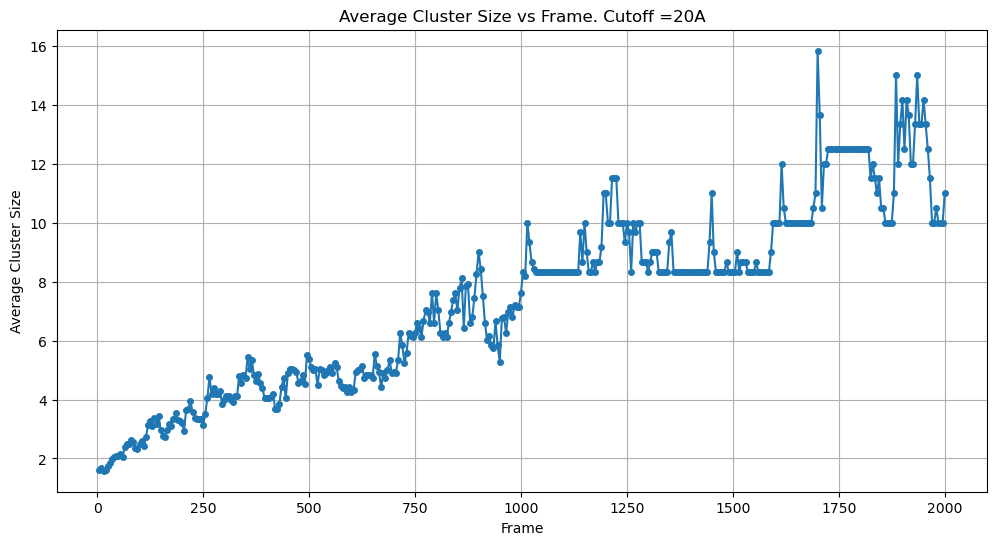

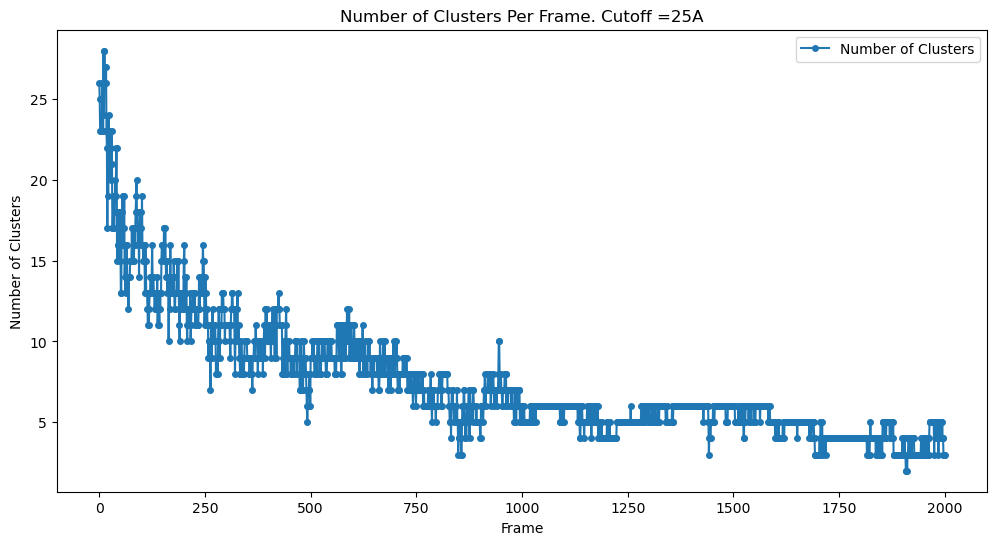

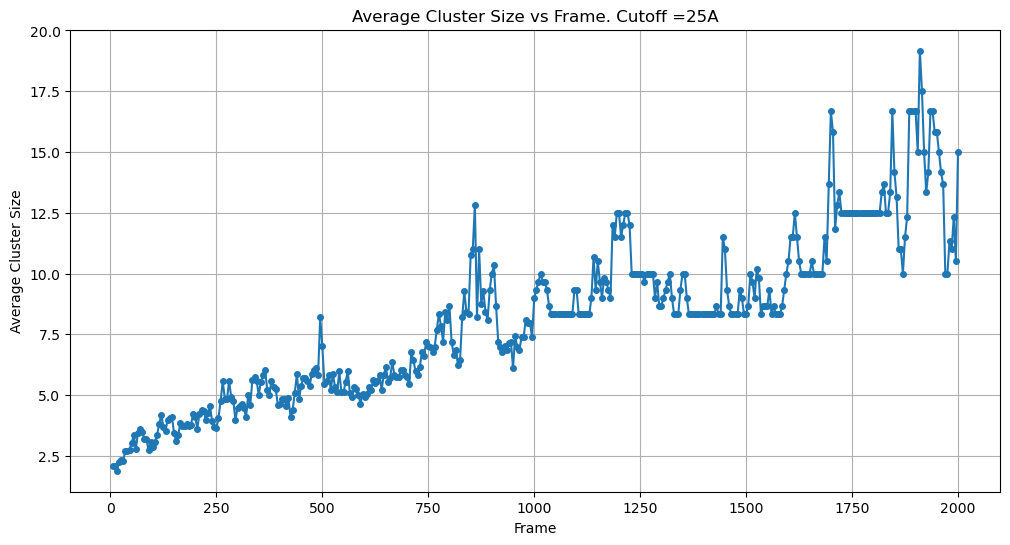

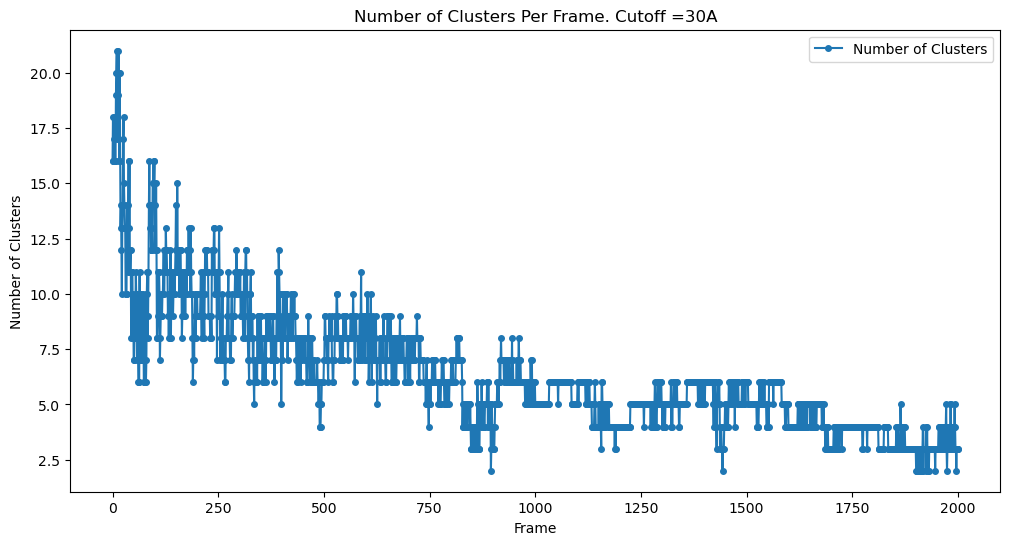

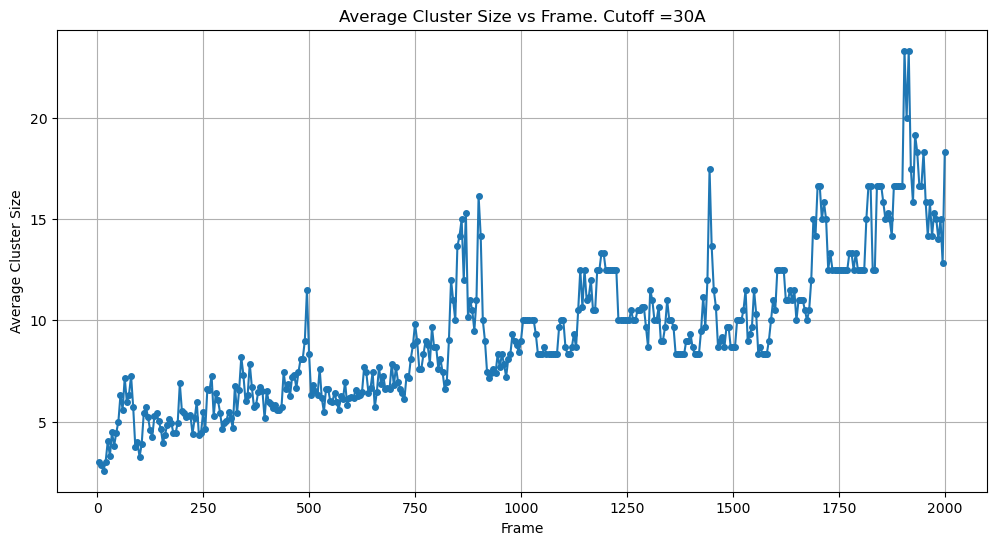

In [20]:
for i, clust_per_frame in enumerate(clusts):
    frames = plot_cluster(clust_per_frame, cutoffs[i])

In [15]:
clusters_per_frame = clusts[0]
cluster_assignments_per_frame = {}

for frame in frames:
    clusters = clusters_per_frame[frame]  # Retrieve clusters for the current frame
    assignments = {}  # To store cluster assignments for this frame

    for cluster_id, cluster in enumerate(clusters):
        for protein in cluster:
            assignments[protein] = cluster_id  # Assign cluster ID to the protein

    cluster_assignments_per_frame[frame] = assignments
    #print(cluster_assignments_per_frame)

#Example: Print cluster assignments for the first frame
# print("Cluster assignments for Frame 0:")
# for protein, cluster_id in cluster_assignments_per_frame[0].items():
#     print(f"Protein {protein}: Cluster {cluster_id}")

In [16]:

import plotly.graph_objects as go
import matplotlib.pyplot as plt


window_size = n # Adjust this to change the smoothing level

print(coms.shape)
# Create a function to compute averaged positions
def average_positions(coms, frame_idx, window_size):
    start_idx = max(0, frame_idx -  window_size)
    end_idx = min(n_frames, frame_idx)
    return np.mean(coms[start_idx:end_idx], axis=0)

# Example data: Replace with your actual data
# `coms` contains the center of mass positions for each protein in each frame
# `cluster_assignments_per_frame` is your dictionary with cluster assignments
n_frames = len(frames)
n_proteins = len(cluster_assignments_per_frame[n])
print(n_proteins)
print(n_frames)


# Generate a consistent set of colors for clusters
assignments = cluster_assignments_per_frame[n]  # Cluster assignments for this frame
clusters = [assignments[protein] for protein in range(n_proteins)]  # Cluster IDs for all proteins in this frame
n_clusters = np.max(clusters)+1
cluster_colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))

# Create Plotly frames for animation
frames = []
for frame_id in range(1, n_frames):
    frame_idx = frame_id*n
    #print(frame_idx)
    assignments = cluster_assignments_per_frame[frame_idx]  # Cluster assignments for this frame
    clusters = [assignments[protein] for protein in range(n_proteins)]  # Cluster IDs for all proteins in this frame
    n_clusters = np.max(clusters)+1
    cluster_colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))
    cluster_colors = ["rgb({}, {}, {})".format(int(c[0]*255), int(c[1]*255), int(c[2]*255)) for c in cluster_colors]
    
    # Compute averaged positions
    avg_coms = average_positions(coms, frame_idx, window_size)
    scatter = go.Scatter3d(
        x=avg_coms[:, 0],
        y=avg_coms[:, 1],
        z=avg_coms[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=[cluster_colors[cluster_id % len(cluster_colors)] for cluster_id in clusters],  # Map clusters to colors
        )
    )
    frames.append(go.Frame(data=[scatter], name=str(frame_idx)))

# Initial frame (first frame)
initial_assignments = cluster_assignments_per_frame[n]
initial_clusters = [initial_assignments[protein] for protein in range(n_proteins)]
initial_scatter = go.Scatter3d(
    x=coms[0, :, 0],
    y=coms[0, :, 1],
    z=coms[0, :, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=[cluster_colors[cluster_id % len(cluster_colors)] for cluster_id in initial_clusters],
    )
)

# Create the figure
fig = go.Figure(
    data=[initial_scatter],
    layout=go.Layout(
        title="Cluster Assignments Over Time",
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z"
        ),
        updatemenus=[dict(
            type="buttons",
            showactive=False,
            buttons=[
                dict(label="Play",
                     method="animate",
                     args=[None, dict(frame=dict(duration=50, redraw=True), fromcurrent=True)]),
                dict(label="Pause",
                     method="animate",
                     args=[[None], dict(frame=dict(duration=0, redraw=False), mode="immediate")])
            ]
        )]
    ),
    frames=frames
)

# Add a slider for interactive navigation
fig.update_layout(
    sliders=[{
        "steps": [
            {
                "args": [[str(frame_idx)], {"frame": {"duration": 50, "redraw": True}, "mode": "immediate"}],
                "label": str(frame_idx*n),
                "method": "animate"
            } for frame_idx in range(1, n_frames-n)
        ],
        "currentvalue": {"prefix": "Frame: "},
    }]
)

# Show the plot
fig.show()

(2001, 50, 3)
50
400


/opt/conda/envs/gromacs/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/envs/gromacs/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
